In [1]:
#pip install colour

In [2]:
#pip install geopy

In [3]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import math
from geopy.geocoders import Nominatim 
import folium
import requests


#### Preparing the data

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
# Preparing the dataframe
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

df_ngh = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_ngh = df_ngh.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
df_ngh = df_ngh[df_ngh['Borough'] == 'Manhattan'].reset_index(drop=True)

In [8]:
df_ngh[0:3]

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900


### Importing details about the neighborhoods

In [10]:
# Itializing the credentials for FourSquare
CLIENT_ID = 'Y2I1UEIHKILT4WF44LFF3LO1103IPOYI41O5OXS0HLI1EOYV' # your Foursquare ID
CLIENT_SECRET = 'SEOER1DQW4QQSPI1KW2L4GAK5LWKS5M5KPABCFBPCSQCDWJ1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 200

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
df_venues = getNearbyVenues(names=df_ngh['Neighborhood'],
                                   latitudes=df_ngh['Latitude'],
                                   longitudes=df_ngh['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Saving to / Reading from file in order to prevent too many Foursquare calls

In [13]:
#df_venues.to_csv('venues_NY.csv', index = True, sep = ';', encoding = 'UTF-8')

In [9]:
df_venues = pd.read_csv('venues_NY.csv', sep = ';', encoding = 'UTF-8')

In [10]:
df_venues

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place
1,1,Marble Hill,40.876551,-73.910660,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,2,Marble Hill,40.876551,-73.910660,Tibbett Diner,40.880404,-73.908937,Diner
3,3,Marble Hill,40.876551,-73.910660,Dunkin',40.877136,-73.906666,Donut Shop
4,4,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
...,...,...,...,...,...,...,...,...
3306,3306,Hudson Yards,40.756658,-74.000111,NY Waterway 42nd St Bus,40.760050,-74.003379,Bus Station
3307,3307,Hudson Yards,40.756658,-74.000111,Gray Line New York Sightseeing Cruises - Pier 78,40.759721,-74.003982,Harbor / Marina
3308,3308,Hudson Yards,40.756658,-74.000111,Twilight Cruise By Citysightseeing,40.759744,-74.004096,Boat or Ferry
3309,3309,Hudson Yards,40.756658,-74.000111,City Lights Cruises,40.759804,-74.004025,Boat or Ferry


In [11]:
df_venues.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Battery Park City,99,99,99,99,99,99,99
Carnegie Hill,100,100,100,100,100,100,100
Central Harlem,44,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100,100
Clinton,100,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40,40
East Village,100,100,100,100,100,100,100


Removing from the analysis venues with less than 20 occurences in Manhattan

In [12]:
ven_count = df_venues.groupby('Venue Category').count()['Neighborhood']
th = 20
rel_ven = ven_count[ven_count>th].index.values

In [13]:
df_venues = df_venues[df_venues['Venue Category'].isin(rel_ven)]
#df_venues['Venue Category'].isin(rel_ven)
#df_venues['Venue Category']

Calculating the relative density of venues in each Neighborhood

In [14]:
df_enc = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
df_enc['Neighborhood'] = df_venues['Neighborhood'] 
fixed_columns = [df_enc.columns[-1]] + list(df_enc.columns[:-1])
df_enc = df_enc[fixed_columns]

In [15]:
df_freq = df_enc.groupby('Neighborhood').mean().reset_index()
df_freq.head()

,Neighborhood,American Restaurant,Art Gallery,Bagel Shop,Bakery,Bar,Bookstore,Boutique,Burger Joint,Café,...,Seafood Restaurant,Spa,Steakhouse,Sushi Restaurant,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Battery Park City,0.020408,0.000000,0.000000,0.020408,0.000000,0.000000,0.020408,0.040816,0.000000,...,0.000000,0.000000,0.020408,0.020408,0.000000,0.000000,0.000000,0.000000,0.040816,0.000000
1,Carnegie Hill,0.013889,0.000000,0.013889,0.041667,0.027778,0.041667,0.000000,0.013889,0.069444,...,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.013889,0.013889,0.041667,0.041667
2,Central Harlem,0.076923,0.076923,0.038462,0.000000,0.076923,0.038462,0.038462,0.000000,0.038462,...,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.048387,0.032258,0.016129,0.080645,0.016129,0.032258,0.000000,0.000000,0.016129,...,0.032258,0.000000,0.000000,0.032258,0.016129,0.048387,0.016129,0.000000,0.048387,0.000000
4,Chinatown,0.075472,0.000000,0.000000,0.056604,0.037736,0.018868,0.037736,0.000000,0.000000,...,0.000000,0.056604,0.000000,0.000000,0.018868,0.000000,0.018868,0.000000,0.000000,0.018868


## Method a: Cluster Analysis 

In [16]:
from sklearn.cluster import DBSCAN

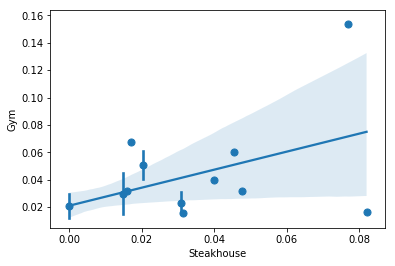

In [17]:
width = 6
height = 4
plt.figure(figsize=(width, height))
sns_plot = sns.regplot(x="Steakhouse", y="Gym", data=df_freq, x_estimator=np.mean)
#plt.ylim(0,)
#fig = sns_plot.get_figure()
#fig.savefig("output.png")

In [18]:
df_corr = df_freq.corr(method='pearson', min_periods=1) 
df_corr.head()

,American Restaurant,Art Gallery,Bagel Shop,Bakery,Bar,Bookstore,Boutique,Burger Joint,Café,Chinese Restaurant,...,Seafood Restaurant,Spa,Steakhouse,Sushi Restaurant,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Yoga Studio
American Restaurant,1.000000,-0.050531,-0.020334,-0.320693,-0.142024,0.330380,0.089409,0.219527,-0.145367,0.061593,...,0.237778,0.224165,0.165514,-0.344105,-0.186381,0.202679,-0.007850,0.080582,0.001075,-0.055258
Art Gallery,-0.050531,1.000000,0.202184,0.144980,-0.116786,0.060470,0.465258,-0.146707,-0.165146,0.064114,...,0.134706,0.046899,-0.189060,0.014387,-0.032570,0.004933,0.097888,-0.171509,-0.088323,0.041972
Bagel Shop,-0.020334,0.202184,1.000000,-0.203334,0.232596,-0.021119,-0.211361,-0.088325,-0.064137,0.037100,...,-0.045780,0.163229,-0.224838,0.032601,0.229319,-0.046775,0.076591,-0.001058,0.052171,-0.114592
Bakery,-0.320693,0.144980,-0.203334,1.000000,-0.304954,-0.077748,0.150775,-0.264646,0.224090,0.308919,...,-0.055006,0.087514,-0.170864,-0.057046,0.320474,0.029174,0.098838,0.097479,0.170194,0.068548
Bar,-0.142024,-0.116786,0.232596,-0.304954,1.000000,-0.145379,-0.144990,-0.240707,-0.222501,0.035424,...,-0.106617,0.002023,-0.172811,-0.139653,-0.038317,-0.149922,-0.031872,-0.031121,-0.060696,-0.172173


#### Preparing the distance matrix

In [19]:
# Loading the data into a matrix and ignoring negative correlations, they will be relevant in a second time
dmatrix = df_corr.where(abs(df_corr)>0.3).fillna(0).values
dmatrix[dmatrix<0] = 0
dmatrix = 1 - dmatrix
dmatrix[0]

array([0.        , 1.        , 1.        , 1.        , 1.        ,
       0.66961979, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.62286089, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

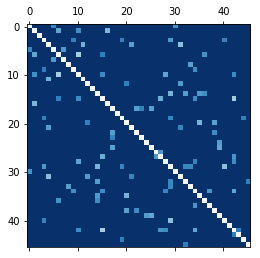

In [20]:
sns_plot = plt.matshow(dmatrix, cmap=plt.cm.Blues, fignum=1)
#fig = sns_plot.get_figure()
#fig.savefig("distance_matrix.png")

#### Clustering the Venues Categories

In [21]:
db_clustering = DBSCAN(eps=0.6, min_samples=2, metric = 'precomputed').fit(dmatrix)
clist = db_clustering.labels_
print('Categories not clustered:', len(clist[clist == -1]) / len(clist) * 100, '%')

Categories not clustered: 30.434782608695656 %


In [22]:
df_clustered = df_corr.copy()
df_clustered['cluster'] = clist
sr_cluster = df_clustered['cluster']

In [23]:
sr_cluster[sr_cluster == -1]

American Restaurant       -1
Bagel Shop                -1
Chinese Restaurant        -1
Cosmetics Shop            -1
Greek Restaurant          -1
Grocery Store             -1
Ice Cream Shop            -1
New American Restaurant   -1
Seafood Restaurant        -1
Spa                       -1
Theater                   -1
Wine Bar                  -1
Wine Shop                 -1
Yoga Studio               -1
Name: cluster, dtype: int64

In [24]:
sr_cluster = sr_cluster[sr_cluster != -1].sort_values(axis = 0)
sr_cluster

Art Gallery                      0
Boutique                         0
Clothing Store                   0
Mediterranean Restaurant         0
French Restaurant                0
Bakery                           1
Steakhouse                       1
Sandwich Place                   1
Pizza Place                      1
Mexican Restaurant               1
Deli / Bodega                    1
Thai Restaurant                  1
Gym                              1
Park                             2
Gym / Fitness Center             2
Bar                              2
Coffee Shop                      2
Cocktail Bar                     2
Bookstore                        3
Burger Joint                     3
Café                             4
Restaurant                       4
Salon / Barbershop               5
Dessert Shop                     5
Korean Restaurant                5
Japanese Restaurant              5
Vegetarian / Vegan Restaurant    5
Italian Restaurant               6
Indian Restaurant   

## Method b: Recommender System

In [25]:
df_nfreq = df_freq.transpose()
df_nfreq.columns = df_nfreq.loc['Neighborhood', :]
df_nfreq = df_nfreq.drop('Neighborhood')
df_nfreq.columns
df_nfreq[df_nfreq.columns] = df_nfreq[df_nfreq.columns].apply(pd.to_numeric)

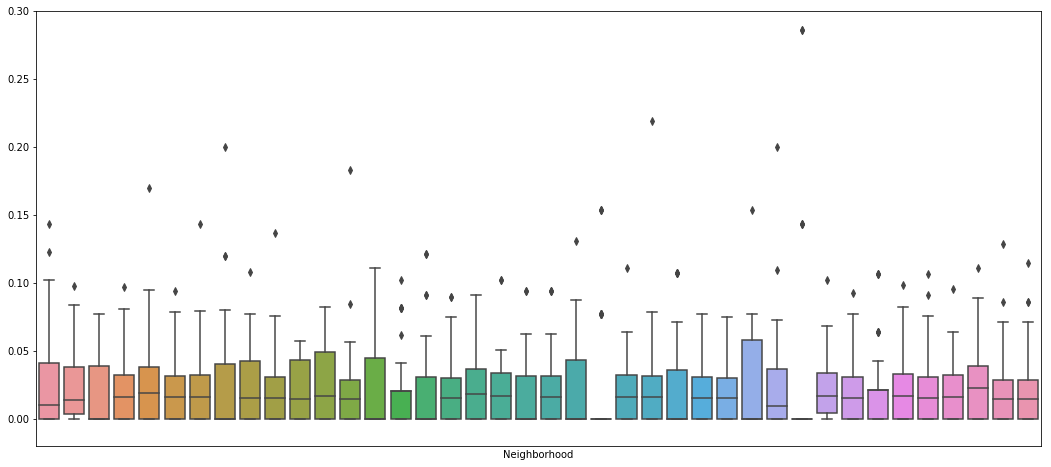

In [26]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
width = 18
height = 8
plt.figure(figsize=(width, height))
sns_plot = sns.boxplot(data=df_nfreq)
plt.ylim(-0.02,0.3)
plt.xticks([])
plt.rc('ytick', labelsize=22) 
#plt.rc('xlabel', labelsize=40) 
plt.rc('font', **font)
fig = sns_plot.get_figure()
fig.savefig("densities.png")

In [27]:
df_ncorr = df_nfreq.corr(method='pearson') 
df_ncorr.head()

Neighborhood,Battery Park City,Carnegie Hill,Central Harlem,Chelsea,Chinatown,Civic Center,Clinton,East Harlem,East Village,Financial District,...,Stuyvesant Town,Sutton Place,Tribeca,Tudor City,Turtle Bay,Upper East Side,Upper West Side,Washington Heights,West Village,Yorkville
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Battery Park City,1.000000,0.213107,-0.144041,0.391297,-0.062070,0.406671,0.156770,-0.008808,-0.009890,0.489706,...,0.374693,0.193958,0.337531,0.318757,0.306922,0.272838,0.018493,0.238060,0.202104,0.340891
Carnegie Hill,0.213107,1.000000,0.061174,0.357973,-0.073743,0.402238,0.042027,0.025836,0.120479,0.507545,...,0.119468,0.230991,0.129513,0.290600,0.240370,0.319387,0.409990,0.476031,0.164750,0.426228
Central Harlem,-0.144041,0.061174,1.000000,-0.062930,0.299548,0.094552,-0.060050,-0.062846,0.122362,0.159897,...,0.255022,-0.008305,0.140761,0.051312,-0.152523,0.170828,-0.012567,-0.010891,0.036539,-0.024795
Chelsea,0.391297,0.357973,-0.062930,1.000000,0.087960,0.438108,0.409963,0.004697,0.188614,0.414550,...,0.084650,0.230831,0.308264,-0.025888,0.393282,0.599604,0.443819,0.253582,0.468378,0.403250
Chinatown,-0.062070,-0.073743,0.299548,0.087960,1.000000,-0.006440,0.025259,0.186239,0.390545,0.124366,...,0.054270,0.032086,0.138886,-0.132644,-0.202281,0.054510,-0.051298,0.068539,0.182523,-0.046866


In [28]:
c1 = 'Tribeca'
#c2 = nser[nser == (nser[nser!=1].max()) ].index.values[0]
c2 = 'Hudson Yards'
print(c1,'/', c2)

Tribeca / Hudson Yards


c:\users\mkorbman\appdata\local\programs\python\python37\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


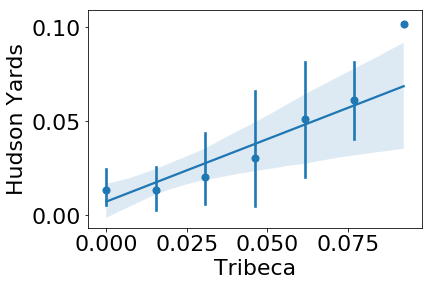

In [29]:
width = 6
height = 4
plt.figure(figsize=(width, height))
sns_plot = sns.regplot(x=c1, y=c2, data=df_nfreq, x_estimator=np.mean)
#fig = sns_plot.get_figure()
#fig.savefig("Tri_Hud.png")

In [30]:
df_ncorr['Tribeca'].nlargest(7)

Neighborhood
Tribeca               1.000000
Hudson Yards          0.539945
Civic Center          0.505199
Turtle Bay            0.474826
Lincoln Square        0.467460
West Village          0.434982
Financial District    0.394302
Name: Tribeca, dtype: float64

#### Setting up the recommender analysis on a specific neighborhood

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [32]:
sq_err = np.array([])
ng = 'Central Harlem'
exp = []
exp = np.array(exp)
act = []
act = np.array(act)
for cx in df_nfreq.index:
    df_nfreq_test = df_nfreq.drop(cx)
    df_ncorr_test = df_nfreq_test.corr(method='pearson')
    weights = df_ncorr_test[ng]
    weights[weights<0.2] = 0
    weights = weights.drop(ng)
    cp = df_nfreq.loc[cx,:]
    cp = cp.drop(ng)
    exp_cx = sum(weights * cp) / sum(weights)
    exp = np.append(exp, exp_cx)
    act = np.append(act, df_nfreq.loc[cx, ng])
diff = exp - act
sq_err_ng = np.sqrt(sum(diff*diff/len(exp))) 
sq_err = np.append(sq_err, sq_err_ng)

In [33]:
print('The model has an average deviation of', np.sqrt(sum(diff*diff/len(exp))), 'in', ng )
#np.sqrt(((diff)**2).mean(axis=0))

The model has an average deviation of 0.04137403690917762 in Central Harlem


In [34]:
np.mean(abs(diff))
diff

array([-0.04185497, -0.07692308, -0.03846154,  0.0439134 , -0.03918723,
       -0.02833451, -0.01842844,  0.        , -0.03846154, -0.07692308,
        0.        ,  0.07798904,  0.10190663, -0.069476  , -0.03846154,
       -0.01842844, -0.07692308,  0.        ,  0.02086915,  0.01182552,
       -0.02833451,  0.02389976,  0.01026499,  0.02086915,  0.01182552,
        0.07537201,  0.        ,  0.01026499,  0.        ,  0.05735677,
        0.01026499,  0.08969921, -0.02833451,  0.        ,  0.03190909,
        0.02086915, -0.07692308, -0.00863866,  0.        ,  0.01182552,
        0.01026499,  0.        ,  0.01026499,  0.        ,  0.        ,
        0.01026499])

(array([ 5.,  1.,  7.,  3., 19.,  4.,  2.,  1.,  2.,  2.]),
 array([-0.07692308, -0.05904011, -0.04115713, -0.02327416, -0.00539119,
         0.01249178,  0.03037475,  0.04825772,  0.06614069,  0.08402366,
         0.10190663]),
 <a list of 10 Patch objects>)

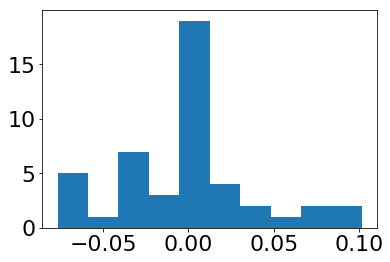

In [35]:
plt.hist(diff, bins=10)

#### Applying the model on the whole dataset

#### Step 1: how to calculate the expected value

In [36]:
LR = LinearRegression()  
LR.fit(df_nfreq['Tribeca'].values.reshape(-1,1), df_nfreq['Hudson Yards'].values) 
LR.coef_, LR.intercept_, np.sqrt(LR.score(df_nfreq['Tribeca'].values.reshape(-1,1), df_nfreq['Hudson Yards'].values))

(array([0.6655964]), 0.007269643437279812, 0.539944964109556)

Retrieving the interpolation slope and intercept

In [37]:
LR = LinearRegression()
n = len(df_nfreq.columns)
Mcoef = np.zeros(shape=(n,n))
Mintr = np.zeros(shape=(n,n))
for i in range(0, n):
    for j in range(0, n):
        col1 = df_nfreq.columns[i]
        col2 = df_nfreq.columns[j]
        LR.fit(df_nfreq[col1].values.reshape(-1,1), df_nfreq[col2].values)
        Mcoef[i][j] = LR.coef_
        #Mcoef[j][i] = Mcoef[i][j] not a symmetric matrix
        Mintr[i][j] = LR.intercept_
        #Mintr[i][j] = Mintr[j][i] not a symmetric matrix

In [38]:
df_coef = pd.DataFrame(data=Mcoef, index=df_nfreq.columns, columns=df_nfreq.columns)
df_intr = pd.DataFrame(data=Mintr, index=df_nfreq.columns, columns=df_nfreq.columns)

Comparing the different methods: direct or interpolation

In [39]:
tot_rd = 0
tot_ri = 0
tot_ra = 0
for ng in df_nfreq.columns: 
    #cx = 'Boutique'
    s_diff = pd.Series([])
    errd = np.array([])
    erri = np.array([])
    erra = np.array([])
    for cx in df_nfreq.index:
        df_nfreq_test = df_nfreq.drop(cx)
        df_ncorr_test = df_nfreq_test.corr(method='pearson') 
        weights = df_ncorr_test[ng] # the weights are the correlation coefficients
        weights[weights<0] = 0 # ignoring negative correlations
        weights = weights.drop(ng) # skipping the auto-correlation
        cp = df_nfreq.loc[cx,:] # actual values in the other neighborhoods
        cp = cp.drop(ng) # skipping the known value of the test
        coef = df_coef[ng].drop(ng) # slope of the linear correlation
        intr = df_intr[ng].drop(ng) # intercept of the linear correlation
        exp_cp = cp * coef + intr
        exp_cxd = sum(weights * cp) / sum(weights)
        #print('direct:', exp_cxd)
        exp_cxi = sum(weights * exp_cp) / sum(weights)
        actual = df_nfreq.loc[cx, ng]
        exp_cxa = (exp_cxi+exp_cxd)/2
        errd = np.append(errd, actual - exp_cxd)
        erri = np.append(erri, actual - exp_cxi)
        erra = np.append(erra, actual - exp_cxa)
rd = np.sqrt(sum(errd**2)/len(errd))
ri = np.sqrt(sum(erri**2)/len(erri))
ra = np.sqrt(sum(erra**2)/len(erra))
print('Deviation with the direct method:',rd)
print('Deviation with the interpolation method: ',ri)
print('Deviation with the average method: ',ra)

Deviation with the direct method: 0.022027029396014638
Deviation with the interpolation method:  0.023622163210568703
Deviation with the average method:  0.02246766283898296


In [40]:
deviation = rd
deviation

0.022027029396014638

#### Step 2: Calculating the results and integrating them in a map

In [41]:
df_delta = pd.DataFrame(index=df_nfreq.index) 
df_exp = pd.DataFrame(index=df_nfreq.index) 
sq_err = np.array([])
stat_min = 3
for ng in df_nfreq.columns: 
    #print(ng)
    exp = []
    exp = np.array(exp)
    act = []
    act = np.array(act)
    for cx in df_nfreq.index:
        df_nfreq_test = df_nfreq.drop(cx)
        df_ncorr_test = df_nfreq_test.corr(method='pearson') 
        weights = df_ncorr_test[ng]
        weights[weights<0] = 0
        weights = weights.drop(ng)
        cp = df_nfreq.loc[cx,:]
        cp = cp.drop(ng)
        #exp_cx = 0
        #if len(weights[weights!=0]) >= stat_min:
        exp_cx = sum(weights * cp) / sum(weights)
        exp = np.append(exp, exp_cx)
        act = np.append(act, df_nfreq.loc[cx, ng])
        #print(ng, exp_cx, df_nfreq.loc[cx, ng])
    diff = exp - act
    df_delta[ng] = diff
    df_exp[ng] = exp
    sq_err_ng = np.sqrt(sum(diff**2)/len(exp))
    sq_err = np.append(sq_err, sq_err_ng)
sr_sqerr = pd.Series(sq_err, index = df_nfreq.columns) 

In [42]:
# Preparing the color shades for the markers
from colour import Color
red = Color("red")
blue = Color("dodgerblue")
c_red = list(red.range_to(Color("darkred"),3))
c_blue = list(blue.range_to(Color("darkblue"),3))

In [43]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

#add markers to the map
for ng in df_delta.columns:
    lat = df_ngh[df_ngh['Neighborhood'] == ng]['Latitude'].values[0]
    lon = df_ngh[df_ngh['Neighborhood'] == ng]['Longitude'].values[0]
    folium.Marker( [lat + 0.0005, lon+0.0003], popup = ng).add_to(map_clusters)
    delta = df_delta[ng]/deviation
    delta = delta[abs(delta) >  1]
    #delta = delta[delta >  0.022]
    i = 1
    for item in delta.iteritems():
        shiftlat = (i * 0.00002) * np.cos(np.random.randint(0,9)* np.pi)
        shiftlon = (i * 0.00002) * np.cos(np.random.randint(0,9)* np.pi)
        lat = lat + shiftlat
        lon = lon + shiftlon
        label = folium.Popup(item[0], parse_html=False)
        d = item[1]
        if d < 0: 
            d = abs(d)
            if d > 2: color = c_red[2].hex
            if (d > 1.5 and d < 2) : color = c_red[1].hex
            if (d > 1 and d < 1.5) : color = c_red[0].hex
        else:
            if d > 2: color = c_blue[2].hex
            if (d > 1.5 and d < 2) : color = c_blue[1].hex
            if (d > 1 and d < 1.5) : color = c_blue[0].hex
                
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup = item[0],
            color = color,
            fill=True,
            fill_color = color,
            fill_opacity=0.7).add_to(map_clusters)
        i = i+1 
       
map_clusters

#### Example in East Village

In [45]:
#plt.hist(df_delta['Central Harlem'].values, bins=10)
#sr_sqerr
ng = 'East Village'
cp = 'Café'
df_nfreq[ng][cp], df_exp[ng][cp], df_delta[ng][cp]
df_delta[df_delta > 0.022].iloc[:,20:40]
df_delta[ng]/0.022
#df_nfreq['Midtown South']

American Restaurant              0.127183
Art Gallery                     -0.066001
Bagel Shop                      -0.686982
Bakery                           0.916402
Bar                             -3.188740
Bookstore                        0.512758
Boutique                         0.436951
Burger Joint                    -0.404602
Café                             1.900351
Chinese Restaurant              -1.431520
Clothing Store                   0.420196
Cocktail Bar                    -1.069094
Coffee Shop                      0.983477
Cosmetics Shop                   0.759378
Deli / Bodega                    1.057516
Dessert Shop                    -0.808426
French Restaurant                0.046276
Gourmet Shop                    -0.356456
Greek Restaurant                -0.277287
Grocery Store                    0.835597
Gym                              1.101169
Gym / Fitness Center             1.416060
Hotel                            1.022655
Ice Cream Shop                  -2

In [46]:
ng = 'East Village'
pd.DataFrame({'delta '+ng : df_delta[ng]/0.022, 'freq '+ng: df_nfreq[ng]})
weights = df_ncorr[ng]
weights[weights<0] = 0
nng = weights[weights!=1].nlargest()
nng
ng0 = nng.index[0]
pd.DataFrame({'freq '+ng0 : df_nfreq[ng0], 'freq '+ng: df_nfreq[ng]})

,freq Gramercy,freq East Village
American Restaurant,0.049180,0.030769
Art Gallery,0.016393,0.015385
Bagel Shop,0.065574,0.030769
Bakery,0.016393,0.015385
Bar,0.081967,0.107692
Bookstore,0.000000,0.000000
Boutique,0.000000,0.000000
Burger Joint,0.000000,0.015385
Café,0.032787,0.000000
Chinese Restaurant,0.000000,0.061538
